In [116]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime


In [124]:
avg_delay_df = pd.read_csv('C:/Users/MSI/avg_delay.csv')
avg_delay_df = pd.to_datetime(avg_delay_df['time'], format='%Y-%m-%d %H:%M:%S%z')

In [127]:
days=[(4,1),(1,1),(1,19),(5,25),(6,19),(7,3),(9,7),(11,11),(11,26),(12,25)]
holidays = []

for j in range(11,32):     
    t = (3,j)
    holidays.append(t)       
for i in days:
    holidays.append(i)
holidays.sort()



summer= []
days_of_summer = {
    6:30,
    7:31,
    8:31
}  
for i in range(6,9):
    for j in range(1,days_of_summer[i]+1):
        summer.append((i,j))
        

In [80]:
airport_name = "ACY"
used_df = avg_delay_df[airport_name]
used2_df = pd.DataFrame({airport_name:used_df})
used2_df['Seconds'] = used2_df.index.map(pd.Timestamp.timestamp)

hour = 60*60
day = 60*60*24
month = 30.4368499*day

used2_df['Day sin'] = np.sin(used2_df['Seconds'] * (2* np.pi / day))
used2_df['Day cos'] = np.cos(used2_df['Seconds'] * (2 * np.pi / day))
used2_df['month sin'] = np.sin(used2_df['Seconds'] * (2 * np.pi / month))
used2_df['month cos'] = np.cos(used2_df['Seconds'] * (2 * np.pi / month))
used2_df = used2_df.drop('Seconds', axis=1)



In [82]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)
X2, y2 = df_to_X_y2(used2_df)
train_size = int(0.7 * len(used2_df))  # 60% for training 4822
val_size = int(0.2 * len(used2_df))    # 20% for validation 1607
test_size = len(used2_df) - train_size - val_size
X2_train, y2_train = X2[:train_size], y2[:train_size]
X2_val, y2_val = X2[train_size:train_size+val_size], y2[train_size:train_size+val_size]
X2_test, y2_test = X2[train_size+val_size:], y2[train_size+val_size:]
used2_df_training_mean = np.mean(X2_train[:, :, 0])
used2_df_training_std = np.std(X2_train[:, :, 0])
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)


array([[[-1.92658629e-01,  2.58819045e-01, -9.65925826e-01,
         -6.21044922e-01,  7.83774971e-01],
        [-1.92658629e-01,  7.16573952e-12, -1.00000000e+00,
         -6.14280473e-01,  7.89087765e-01],
        [-1.92658629e-01, -2.58819045e-01, -9.65925826e-01,
         -6.07470577e-01,  7.94342179e-01],
        ...,
        [-1.92658629e-01, -7.07106781e-01, -7.07106781e-01,
         -5.93716465e-01,  8.04674319e-01],
        [-1.92658629e-01, -8.66025404e-01, -5.00000000e-01,
         -5.86773265e-01,  8.09751280e-01],
        [-1.92658629e-01, -9.65925826e-01, -2.58819045e-01,
         -5.79786654e-01,  8.14768333e-01]],

       [[-1.92658629e-01,  7.16573952e-12, -1.00000000e+00,
         -6.14280473e-01,  7.89087765e-01],
        [-1.92658629e-01, -2.58819045e-01, -9.65925826e-01,
         -6.07470577e-01,  7.94342179e-01],
        [-1.92658629e-01, -5.00000000e-01, -8.66025404e-01,
         -6.00615739e-01,  7.99537826e-01],
        ...,
        [-1.92658629e-01, -8.6602540

In [83]:
X2, y2 = df_to_X_y2(used2_df)
X2.shape, y2.shape

((8031, 7, 5), (8031,))

In [209]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100 , title='model2'):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})

  plt.figure(figsize=(10, 6))
  plt.plot(df['Predictions'][start:end], color='red', label='Predictions')
  plt.plot(df['Actuals'][start:end], color='grey', label='Actuals')
  
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.show()
  
  mse_value = mse(y, predictions)
  
  return df, mse_value
  

In [85]:
X2, y2 = df_to_X_y2(used2_df)
X2.shape, y2.shape

((8031, 7, 5), (8031,))

In [86]:
train_size = int(0.7 * len(used2_df))  # 60% for training 4822
val_size = int(0.2 * len(used2_df))    # 20% for validation 1607
test_size = len(used2_df) - train_size - val_size
X2_train, y2_train = X2[:train_size], y2[:train_size]
X2_val, y2_val = X2[train_size:train_size+val_size], y2[train_size:train_size+val_size]
X2_test, y2_test = X2[train_size+val_size:], y2[train_size+val_size:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((5626, 7, 5), (5626,), (1607, 7, 5), (1607,), (798, 7, 5), (798,))

In [87]:
# standarizing the avg delay
used2_df_training_mean = np.mean(X2_train[:, :, 0])
used2_df_training_std = np.std(X2_train[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - used2_df_training_mean) / used2_df_training_std
  return X

In [88]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[-1.92658629e-01,  2.58819045e-01, -9.65925826e-01,
         -6.21044922e-01,  7.83774971e-01],
        [-1.92658629e-01,  7.16573952e-12, -1.00000000e+00,
         -6.14280473e-01,  7.89087765e-01],
        [-1.92658629e-01, -2.58819045e-01, -9.65925826e-01,
         -6.07470577e-01,  7.94342179e-01],
        ...,
        [-1.92658629e-01, -7.07106781e-01, -7.07106781e-01,
         -5.93716465e-01,  8.04674319e-01],
        [-1.92658629e-01, -8.66025404e-01, -5.00000000e-01,
         -5.86773265e-01,  8.09751280e-01],
        [-1.92658629e-01, -9.65925826e-01, -2.58819045e-01,
         -5.79786654e-01,  8.14768333e-01]],

       [[-1.92658629e-01,  7.16573952e-12, -1.00000000e+00,
         -6.14280473e-01,  7.89087765e-01],
        [-1.92658629e-01, -2.58819045e-01, -9.65925826e-01,
         -6.07470577e-01,  7.94342179e-01],
        [-1.92658629e-01, -5.00000000e-01, -8.66025404e-01,
         -6.00615739e-01,  7.99537826e-01],
        ...,
        [-1.92658629e-01, -8.6602540

In [183]:
model2_LSTM = Sequential()
model2_LSTM.add(InputLayer((7, 5)))
model2_LSTM.add(LSTM(512))
model2_LSTM.add(Dense(128, 'relu'))

model2_LSTM.add(Dense(128, 'relu'))
model2_LSTM.add(Dense(1, 'linear'))
model2_LSTM.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 512)               1060864   
                                                                 
 dense_78 (Dense)            (None, 128)               65664     
                                                                 
 dense_79 (Dense)            (None, 128)               16512     
                                                                 
 dense_80 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1143169 (4.36 MB)
Trainable params: 1143169 (4.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [184]:
cp2_LSTM = ModelCheckpoint('model2_LSTM/', save_best_only=True)
model2_LSTM.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [185]:
model2_LSTM.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp2_LSTM])

Epoch 1/10
175/176 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0475INFO:tensorflow:Assets written to: model2_LSTM\assets


INFO:tensorflow:Assets written to: model2_LSTM\assets


176/176 [==============================] - 11s 52ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 2/10
176/176 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0468INFO:tensorflow:Assets written to: model2_LSTM\assets


INFO:tensorflow:Assets written to: model2_LSTM\assets


176/176 [==============================] - 10s 55ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 3/10
176/176 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0462INFO:tensorflow:Assets written to: model2_LSTM\assets


INFO:tensorflow:Assets written to: model2_LSTM\assets


176/176 [==============================] - 9s 52ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 4/10
176/176 [==============================] - 7s 41ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 5/10
176/176 [==============================] - 8s 47ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 6/10
176/176 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0456INFO:tensorflow:Assets written to: model2_LSTM\assets


INFO:tensorflow:Assets written to: model2_LSTM\assets


176/176 [==============================] - 10s 55ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 7/10
176/176 [==============================] - 8s 43ms/step - loss: 0.0021 - root_mean_squared_error: 0.0453 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 8/10
176/176 [==============================] - 8s 43ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 9/10
176/176 [==============================] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0451INFO:tensorflow:Assets written to: model2_LSTM\assets


INFO:tensorflow:Assets written to: model2_LSTM\assets


176/176 [==============================] - 10s 54ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 10/10
176/176 [==============================] - 7s 42ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338


51/51 [==============================] - 1s 12ms/step


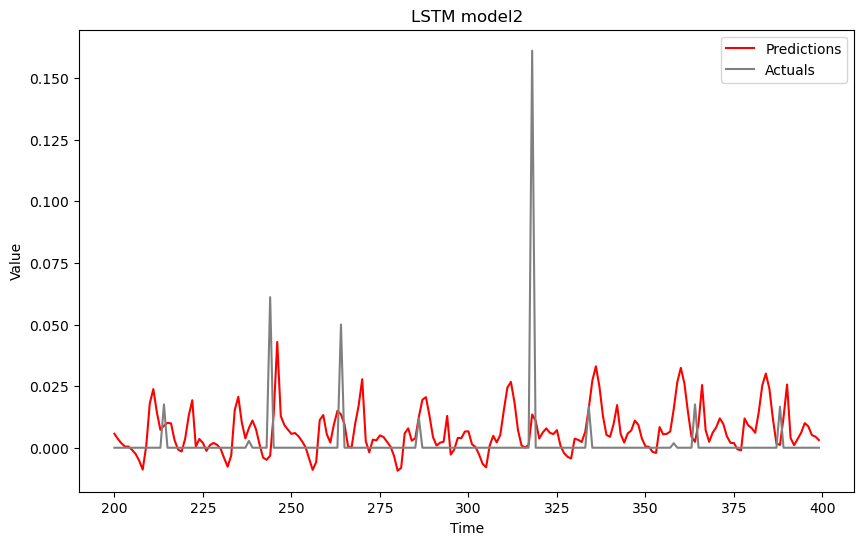

(      Predictions   Actuals
 0        0.020558  0.000000
 1        0.012087  0.000000
 2        0.003311  0.000000
 3        0.006450  0.000000
 4        0.022358  0.035185
 ...           ...       ...
 1602     0.005747  0.000000
 1603     0.004783  0.000000
 1604     0.010079  0.000000
 1605     0.012348  0.000000
 1606     0.012967  0.000000
 
 [1607 rows x 2 columns],
 0.0011437605343360083)

In [210]:
plot_predictions1(model2_LSTM, X2_val, y2_val,200,400,title="LSTM model2")

In [95]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)
X2, y2 = df_to_X_y2(used2_df)
train_size = int(0.7 * len(used2_df))  # 60% for training 4822
val_size = int(0.2 * len(used2_df))    # 20% for validation 1607
test_size = len(used2_df) - train_size - val_size
X2_train, y2_train = X2[:train_size], y2[:train_size]
X2_val, y2_val = X2[train_size:train_size+val_size], y2[train_size:train_size+val_size]
X2_test, y2_test = X2[train_size+val_size:], y2[train_size+val_size:]
used2_df_training_mean = np.mean(X2_train[:, :, 0])
used2_df_training_std = np.std(X2_train[:, :, 0])
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[-1.92658629e-01,  2.58819045e-01, -9.65925826e-01,
         -6.21044922e-01,  7.83774971e-01],
        [-1.92658629e-01,  7.16573952e-12, -1.00000000e+00,
         -6.14280473e-01,  7.89087765e-01],
        [-1.92658629e-01, -2.58819045e-01, -9.65925826e-01,
         -6.07470577e-01,  7.94342179e-01],
        ...,
        [-1.92658629e-01, -7.07106781e-01, -7.07106781e-01,
         -5.93716465e-01,  8.04674319e-01],
        [-1.92658629e-01, -8.66025404e-01, -5.00000000e-01,
         -5.86773265e-01,  8.09751280e-01],
        [-1.92658629e-01, -9.65925826e-01, -2.58819045e-01,
         -5.79786654e-01,  8.14768333e-01]],

       [[-1.92658629e-01,  7.16573952e-12, -1.00000000e+00,
         -6.14280473e-01,  7.89087765e-01],
        [-1.92658629e-01, -2.58819045e-01, -9.65925826e-01,
         -6.07470577e-01,  7.94342179e-01],
        [-1.92658629e-01, -5.00000000e-01, -8.66025404e-01,
         -6.00615739e-01,  7.99537826e-01],
        ...,
        [-1.92658629e-01, -8.6602540

In [212]:
model2_Conv1D = Sequential()
model2_Conv1D.add(InputLayer((7, 5)))
model2_Conv1D.add(Activation('relu'))
model2_Conv1D.add(Conv1D(512 , kernel_size=2))

model2_Conv1D.add(Flatten())
model2_Conv1D.add(Dense(128, 'relu'))
model2_Conv1D.add(Dense(128, 'relu'))
model2_Conv1D.add(Dense(1, 'linear'))
model2_Conv1D.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 activation_6 (Activation)   (None, 7, 5)              0         
                                                                 
 conv1d_19 (Conv1D)          (None, 6, 512)            5632      
                                                                 
 flatten_10 (Flatten)        (None, 3072)              0         
                                                                 
 dense_94 (Dense)            (None, 128)               393344    
                                                                 
 dense_95 (Dense)            (None, 128)               16512     
                                                                 
 dense_96 (Dense)            (None, 1)                 129       
                                                                 
Total params: 415617 (1.59 MB)
Trainable params: 4156

In [213]:
cp2_conv = ModelCheckpoint('model2_conv/', save_best_only=True)
model2_Conv1D.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [214]:
model2_Conv1D.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp2_conv])

Epoch 1/10
172/176 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0547INFO:tensorflow:Assets written to: model2_conv\assets


INFO:tensorflow:Assets written to: model2_conv\assets


176/176 [==============================] - 2s 10ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 2/10
176/176 [==============================] - 1s 5ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 3/10
175/176 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0466INFO:tensorflow:Assets written to: model2_conv\assets


INFO:tensorflow:Assets written to: model2_conv\assets


176/176 [==============================] - 1s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 4/10
173/176 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0460INFO:tensorflow:Assets written to: model2_conv\assets


INFO:tensorflow:Assets written to: model2_conv\assets


176/176 [==============================] - 2s 9ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 5/10
169/176 [===========================>..] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0468INFO:tensorflow:Assets written to: model2_conv\assets


INFO:tensorflow:Assets written to: model2_conv\assets


176/176 [==============================] - 1s 8ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 6/10
175/176 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0457INFO:tensorflow:Assets written to: model2_conv\assets


INFO:tensorflow:Assets written to: model2_conv\assets


176/176 [==============================] - 2s 9ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 7/10
171/176 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0454INFO:tensorflow:Assets written to: model2_conv\assets


INFO:tensorflow:Assets written to: model2_conv\assets


176/176 [==============================] - 1s 8ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 8/10
176/176 [==============================] - 1s 6ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 9/10
176/176 [==============================] - 1s 6ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 10/10
176/176 [==============================] - 1s 5ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355


51/51 [==============================] - 0s 1ms/step


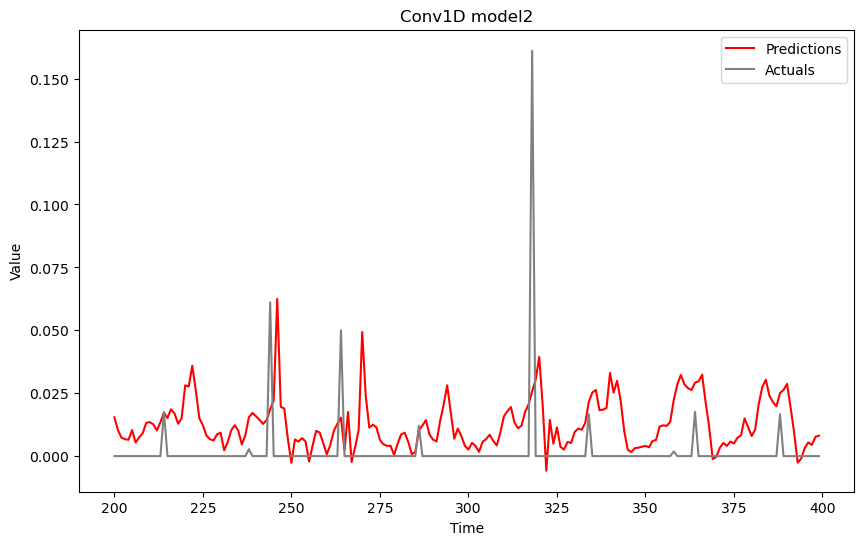

(      Predictions   Actuals
 0        0.019554  0.000000
 1        0.008962  0.000000
 2        0.007816  0.000000
 3        0.006345  0.000000
 4        0.075220  0.035185
 ...           ...       ...
 1602     0.006502  0.000000
 1603     0.009453  0.000000
 1604     0.014958  0.000000
 1605     0.015356  0.000000
 1606     0.013717  0.000000
 
 [1607 rows x 2 columns],
 0.0012624479741182998)

In [215]:
plot_predictions1(model2_Conv1D, X2_val, y2_val,200,400,title="Conv1D model2")

In [198]:
model2_GRU = Sequential()
model2_GRU.add(InputLayer((7, 5)))
model2_GRU.add(GRU(512))
model2_GRU.add(Dense(128, 'relu'))
model2_GRU.add(Dense(128, 'relu'))
model2_GRU.add(Dense(1, 'linear'))
model2_GRU.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 512)               797184    
                                                                 
 dense_88 (Dense)            (None, 128)               65664     
                                                                 
 dense_89 (Dense)            (None, 128)               16512     
                                                                 
 dense_90 (Dense)            (None, 1)                 129       
                                                                 
Total params: 879489 (3.35 MB)
Trainable params: 879489 (3.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [199]:
cp2_gru = ModelCheckpoint('model2_gru/', save_best_only=True)
model2_GRU.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [200]:
model2_GRU.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp2_gru])

Epoch 1/10
176/176 [==============================] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0484INFO:tensorflow:Assets written to: model2_gru\assets


INFO:tensorflow:Assets written to: model2_gru\assets


176/176 [==============================] - 9s 44ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 2/10
176/176 [==============================] - 5s 29ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 3/10
174/176 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0468INFO:tensorflow:Assets written to: model2_gru\assets


INFO:tensorflow:Assets written to: model2_gru\assets


176/176 [==============================] - 7s 39ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 4/10
174/176 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0459INFO:tensorflow:Assets written to: model2_gru\assets


INFO:tensorflow:Assets written to: model2_gru\assets


176/176 [==============================] - 7s 38ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 5/10
175/176 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0460INFO:tensorflow:Assets written to: model2_gru\assets


INFO:tensorflow:Assets written to: model2_gru\assets


176/176 [==============================] - 7s 38ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 6/10
176/176 [==============================] - 5s 28ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 7/10
175/176 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0454INFO:tensorflow:Assets written to: model2_gru\assets


INFO:tensorflow:Assets written to: model2_gru\assets


176/176 [==============================] - 7s 41ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 8/10
176/176 [==============================] - 5s 30ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 9/10
176/176 [==============================] - 5s 31ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0354
Epoch 10/10
176/176 [==============================] - 6s 33ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351


51/51 [==============================] - 1s 10ms/step


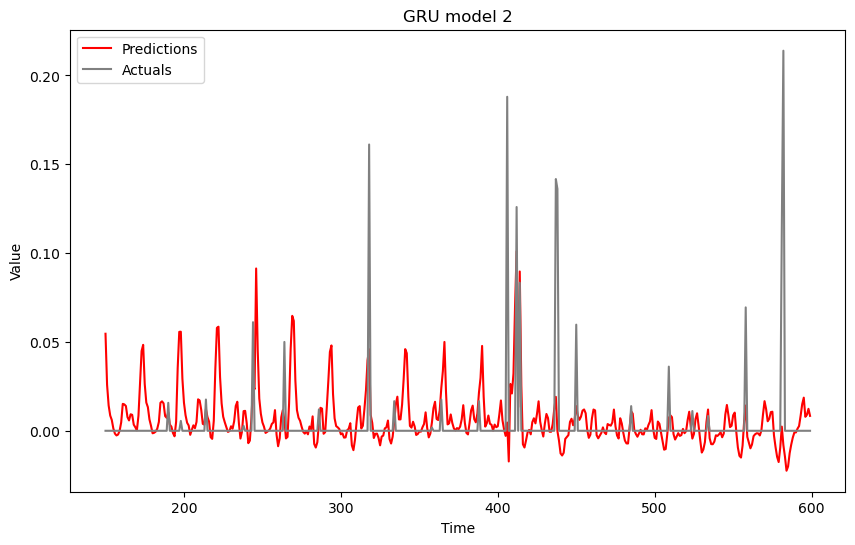

(      Predictions   Actuals
 0        0.014879  0.000000
 1        0.012641  0.000000
 2        0.004368  0.000000
 3        0.009747  0.000000
 4        0.021923  0.035185
 ...           ...       ...
 1602     0.009383  0.000000
 1603     0.005669  0.000000
 1604     0.007777  0.000000
 1605     0.008346  0.000000
 1606     0.006605  0.000000
 
 [1607 rows x 2 columns],
 0.0012291108541906946)

In [216]:
plot_predictions1(model2_GRU, X2_val, y2_val,150,600 ,title="GRU model 2")